<a href="https://colab.research.google.com/github/kavyagl2/Projects_Data-Science/blob/main/Fraud_transactions_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'fraudulent-transactions-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1964310%2F3240868%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240224%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240224T110145Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D16846152bf0a583182d867c89c83a4da8bb2e9b6438d7d46b4cc494be3a3fad402028a3589589f8b17bd14bd2f3a60756253ec412699200f78ad0a216735088c9d37891236be16021af4a4fcc3b5a3d0ed9e27d146a51b45f4d6e650ef257767287a2903335fd2cbb8997f377a245051b4b28205c54fab5e483ef6babee1538a36282bbb6615d65aab61168c7eb787cbd0d0cd4ed9f5bec5e32562d7874ba318ec3babe75d372df308b74701b78eb73b1128c67b180f0b561caa172dc82c6f51a57192ecfa6dec5dae29f4203e2f9a32201afa5b228440db6d37493c213d8b414f7c34c0c16a5fd57a7aeb705e5673584bb05b93aef677c2017dcebd1a5e522b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 186385507 bytes downloaded
Downloaded and uncompressed: fraudulent-transactions-data
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd
import torch

In [ ]:
if torch.cuda.is_available():
    device='cuda'
else:
    device='cpu'

In [ ]:
#reading the data
df= pd.read_csv("/kaggle/input/fraudulent-transactions-data/Fraud.csv")
#getting the number of rows and columns
df.shape

(6362620, 11)

In [ ]:
#head of the data
df.head(200)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
195,1,CASH_OUT,210370.09,C2121995675,0.0,0.00,C1170794006,1442298.03,22190.99,0,0
196,1,CASH_OUT,36437.06,C2120063568,0.0,0.00,C1740000325,154606.00,1363368.51,0,0
197,1,CASH_OUT,82691.56,C1620409359,0.0,0.00,C248609774,657983.89,6453430.91,0,0
198,1,CASH_OUT,338767.10,C691691381,0.0,0.00,C453211571,544481.28,3461666.05,0,0


In [ ]:
#tail of the data
df.tail(200)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
6362420,727,TRANSFER,124582.58,C651444933,124582.58,0.0,C1161818914,0.00,0.00,1,0
6362421,727,CASH_OUT,124582.58,C1098290230,124582.58,0.0,C1739564153,320485.06,445067.64,1,0
6362422,727,TRANSFER,263401.81,C806437930,263401.81,0.0,C1469754483,0.00,0.00,1,0
6362423,727,CASH_OUT,263401.81,C850961884,263401.81,0.0,C1203132980,251586.80,514988.60,1,0
6362424,727,TRANSFER,69039.64,C922622756,69039.64,0.0,C417851521,0.00,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


In [ ]:
#checking for null values if any
df.isnull().values.any()

False

In [ ]:
#collect more information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
#legit transactions
legit = len(df[df.isFraud==0])
#fraud transactions
fraud = len(df[df.isFraud==1])

#legit transactions percentage
legit_perc = round((legit/(legit+fraud))*100,2)

#fraud transactions percentage
fraud_perc = round((fraud/(legit+fraud))*100,2)

print("Number of legit transactions: ",legit)
print("Number of fraud transactions: ",fraud)
print(f"{legit_perc}% are legit transactions in this dataset")
print(f"{fraud_perc}% are fraud transactions in this dataset")




Number of legit transactions:  6354407
Number of fraud transactions:  8213
99.87% are legit transactions in this dataset
0.13% are fraud transactions in this dataset


Since we are dealing with the higly imbalanced data where legit transactions cover around 99.87% while fraud transactions are just 0.13% of the data, the best way to reach the final decision is to work with decision trees and random forests.

In [ ]:
#Merchants
Y = df[df["nameDest"].str.contains('M')]
Y.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

<Axes: >

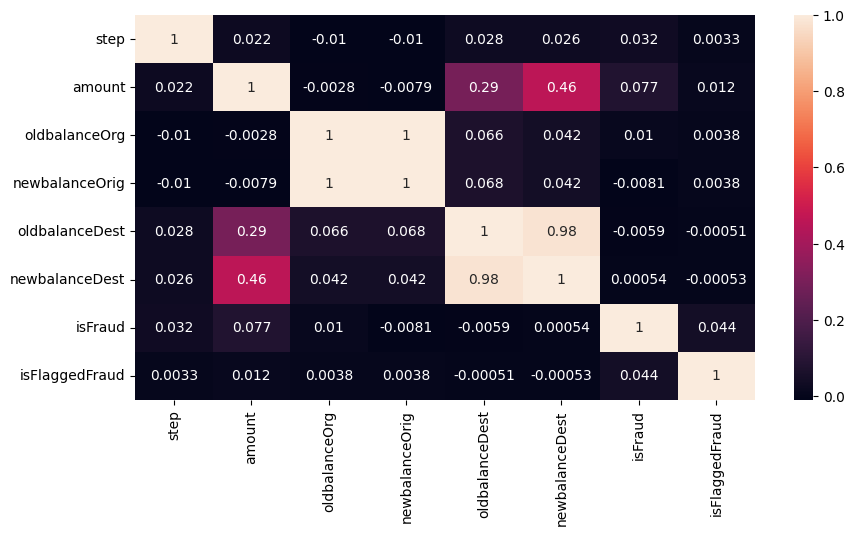

In [ ]:
"""since *type* , *nameOrig* and *nameDest* are objective in nature
we will drop them and create a copy of original data
for vizualizing the correlation heatmap"""

df_corr = df.drop(columns = ["type","nameOrig","nameDest"])
corr = df_corr.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr,annot=True)

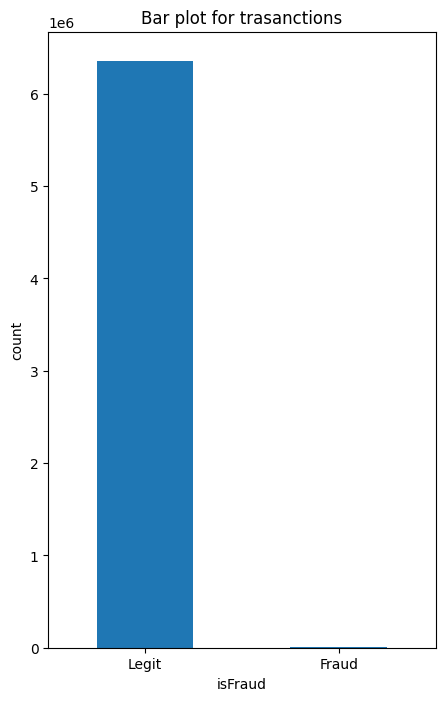

In [ ]:
plt.figure(figsize = (5,8))
labels = ["Legit","Fraud"]
count_classes = df.value_counts(df["isFraud"],sort=True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Bar plot for trasanctions")
plt.ylabel("count")
plt.xticks(range(2), labels)
plt.show()

In [ ]:
#creating a copy for training and testing the data
new_df = df.copy()
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
#checking how many are of object type
list_obj = new_df.select_dtypes(include='object').columns
print(list_obj)

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feat in list_obj:
    new_df[feat] = le.fit_transform(new_df[feat].astype(str))

print(new_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int64  
 2   amount          float64
 3   nameOrig        int64  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int64  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(6)
memory usage: 534.0 MB
None


In [ ]:
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,1,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,1,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0,0


In [ ]:
#checking for multicollinearity in data by using VIF (variance inflation factor)
from statsmodels.stats.outliers_influence import variance_inflation_factor

def cal_vif(new_df):
    vif = pd.DataFrame()
    vif["variables"] = new_df.columns
    vif["VIF"] = [variance_inflation_factor(new_df.values,i) for i in range(new_df.shape[1])]
    return(vif)

cal_vif(new_df)



,variables,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [ ]:
"""NewbalanceOrig and oldbalanceOrg are highly correlated, similar goes with
oldbalancedest and newbalanedest.
Also looking over the information we can see that namedest and nameOrig are connected to each other"""

#combining features with high collinearity and dropping individual ones

new_df["orig_amount"] = new_df.apply(lambda x: x["oldbalanceOrg"]- x["newbalanceOrig"], axis = 1)
new_df["dest_amount"] = new_df.apply(lambda x: x["oldbalanceDest"]- x["newbalanceDest"], axis = 1)
new_df["TransactionPath"] = new_df.apply(lambda x: x["nameDest"]+ x["nameOrig"], axis = 1)

#dropping individual columns
new_df = new_df.drop(['oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','step','nameOrig','nameDest'],axis=1)

cal_vif(new_df)


,variables,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,orig_amount,1.307910
5,dest_amount,3.754335
6,TransactionPath,2.677167


<Axes: >

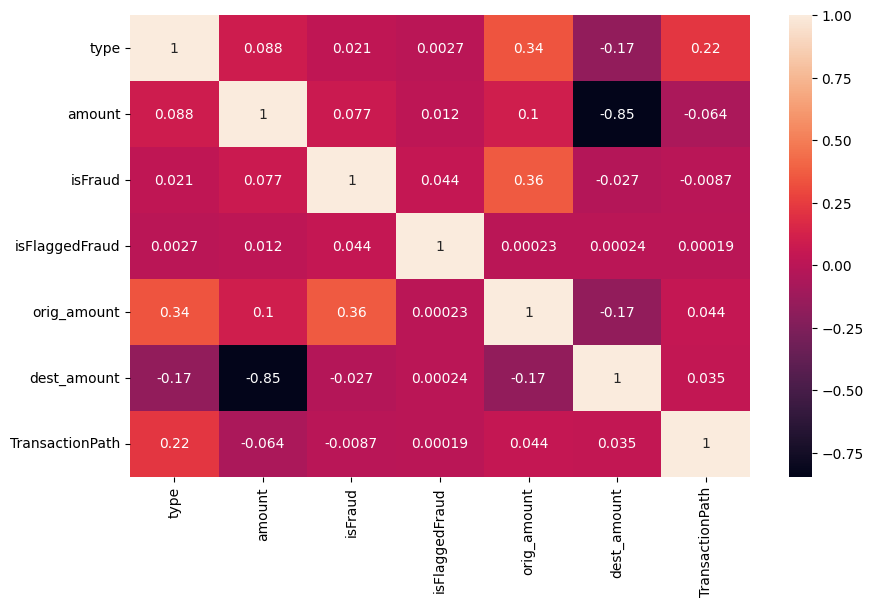

In [ ]:
#generating correlation matrix of the new updated dataframe
corr=new_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

In [ ]:
#importing libraries and modules for building our model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import itertools
from collections import Counter
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#scaling and normalizing our data for better model accuracy and standardization
scaler = StandardScaler()
new_df["NormalizedAmount"] = scaler.fit_transform(new_df["amount"].values.reshape(-1, 1))
new_df.drop(["amount"], inplace= True, axis= 1)

Y = new_df["isFraud"]
X = new_df.drop(["isFraud"], axis= 1)

In [ ]:
#spliting the data in the training and testing dataset
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size= 0.3, random_state= 42)

print("Shape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

Shape of X_train:  (4453834, 6)
Shape of X_test:  (1908786, 6)


In [ ]:
#DECISION TREE
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)

Y_pred_dt = decision_tree.predict(X_test)
decision_tree_score = decision_tree.score(X_test, Y_test)*100

In [ ]:
#RANDOM FORESTS
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)

Y_pred_rf = random_forest.predict(X_test)
random_forest_score = random_forest.score(X_test, Y_test)*100

In [ ]:
#score of classifiers
print("Decision Tree Score: ", decision_tree_score)
print("Random Forests Score: ", random_forest_score)

Decision Tree Score:  99.92366876119166
Random Forests Score:  99.95897916267198


In [ ]:
#confusion matrix for decision tree
print("TP, FP, TN, FN - DECISION TREE")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_dt).ravel()

print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

confusion_matrix_dt = confusion_matrix(Y_test, Y_pred_dt.round())
print("\nConfusion Matrix - Decision Tree")
print(confusion_matrix_dt)

print("---------------------------------------------------------------------------------------------------------")
#confusion matrix for random forests
print("TP, FP, TN, FN - RANDOM FORESTS")
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_rf).ravel()

print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

confusion_matrix_rf = confusion_matrix(Y_test, Y_pred_rf.round())
print("\nConfusion Matrix - Random Forest")
print(confusion_matrix_rf)
print("---------------------------------------------------------------------------------------------------------")


TP, FP, TN, FN - DECISION TREE
True Positives: 1720
False Positives: 742
True Negatives: 1905609
False Negatives: 715

Confusion Matrix - Decision Tree
[[1905609     742]
 [    715    1720]]
---------------------------------------------------------------------------------------------------------
TP, FP, TN, FN - RANDOM FORESTS
True Positives: 1714
False Positives: 62
True Negatives: 1906289
False Negatives: 721

Confusion Matrix - Random Forest
[[1906289      62]
 [    721    1714]]
---------------------------------------------------------------------------------------------------------


In [ ]:
#classification report - dt
classification_dt = classification_report(Y_test, Y_pred_dt)
print("Classification Report - Decision Tree")
print(classification_dt)


print("---------------------------------------------------------------------------------------------------------")

#classification report - rf
classification_rf = classification_report(Y_test, Y_pred_rf)
print("Classification Report - Random Forests")
print(classification_dt)




Classification Report - Decision Tree
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.71      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.85      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786

---------------------------------------------------------------------------------------------------------
Classification Report - Random Forests
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.70      0.71      0.70      2435

    accuracy                           1.00   1908786
   macro avg       0.85      0.85      0.85   1908786
weighted avg       1.00      1.00      1.00   1908786



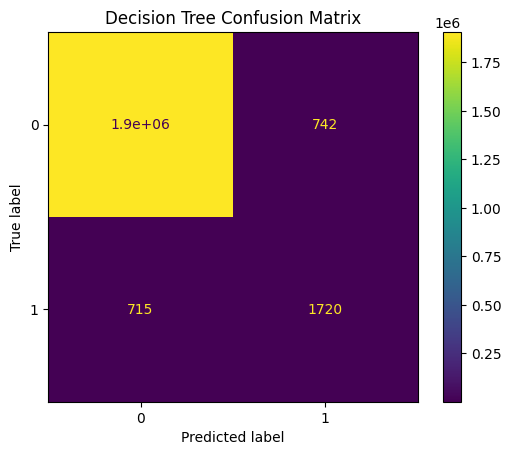

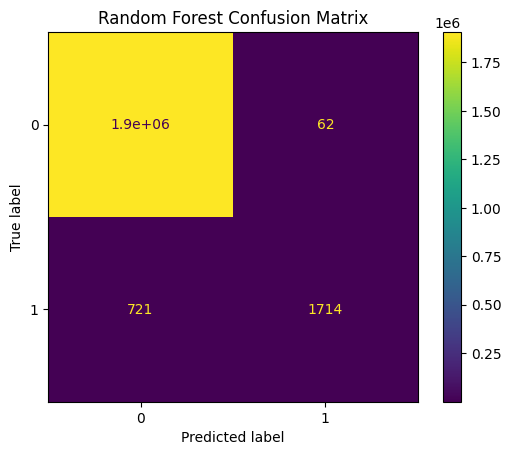

In [ ]:
#confusion matrix - decision tree vizualization
decision_cf = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_dt)
decision_cf.plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()


#confusion matrix - random forests vizualization
random_forest_cf = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rf)
random_forest_cf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()



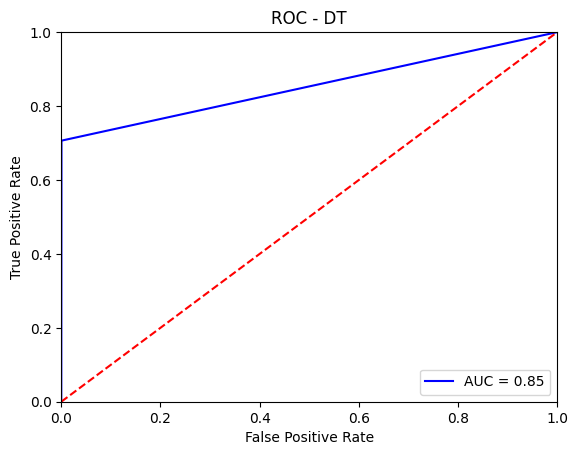

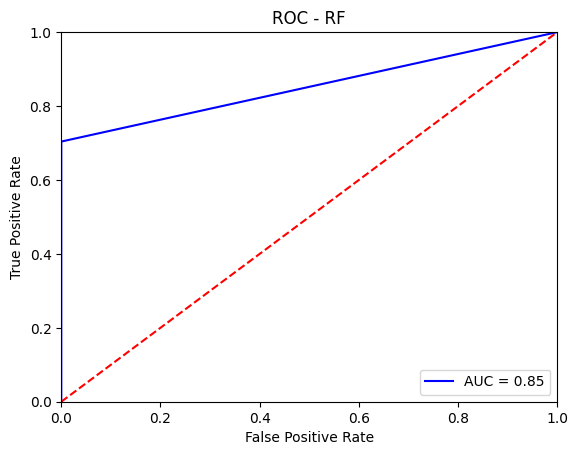

In [ ]:
# AUC ROC - DT
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_dt)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - DT')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


# AUC ROC - RF
# calculate the fpr and tpr for all thresholds of the classification

fpr, tpr, threshold = metrics.roc_curve(Y_test, Y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC - RF')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()